# **MLP**

---

## 0. Importing dependencies

In [1]:
%matplotlib inline

# needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from tensorflow import keras
from keras.callbacks import Callback
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, Activation, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import warnings

warnings.filterwarnings('ignore')

## 1. Loading data

It is already splitted:

In [2]:
train_df = pd.read_csv('../../input/clean_train_df.csv')
test_df = pd.read_csv('../../input/clean_test_df.csv')

## 2. Processing Train and Test sets

Due to class imbalace, there's still few unrelevant countries which aren't in both sets, since data is already one-hot encoded, we should find those countries and drop them off.

In [3]:
# Extract unique columns (features) from the train and test sets
train_countries = set(train_df.columns)
test_countries = set(test_df.columns)

# Find columns that are in the train set but not in the test set
missing_in_test = train_countries - test_countries
print("Columns in the train set that aren't in the test set:", missing_in_test)

missing_in_train = test_countries - train_countries
print("Columns in the test set that aren't in the train set:", missing_in_train)

# Drop columns that are in 'missing_in_test' from the training set
train_df = train_df.drop(columns=missing_in_test)

# Drop columns that are in 'missing_in_train' from the test set
test_df = test_df.drop(columns=missing_in_train)

print(train_df.shape, test_df.shape)

Columns in the train set that aren't in the test set: {'Country_Serbia', 'Country_Kenya', 'Country_Bangladesh', 'Country_Viet Nam', 'Country_Azerbaijan', 'Country_Bosnia-Herz.', 'Country_Malta', 'Country_Georgia', 'Country_Mongolia', 'Country_Kosovo', 'Country_United Arab Emirates', 'Country_Nomadic', 'Country_Estonia', 'Country_Peru', 'Country_Lebanon', 'Country_Jordan', 'Country_Saudi Arabia', 'Country_Slovakia', 'Country_Yemen', 'Country_Uzbekistan', 'Country_Zimbabwe', 'Country_Venezuela', 'Country_Andorra', 'Country_New Zealand', 'Country_Tanzania', 'Country_Philippines', 'Country_Paraguay', 'Country_El Salvador', 'Ethnicity_North American / Central American', 'Country_Botswana', 'Country_Sri Lanka', 'Country_North Macedonia', 'Country_Croatia', 'Country_Cyprus', 'Country_Armenia', 'Country_Angola', 'Country_Costa Rica', 'Country_Latvia'}
Columns in the test set that aren't in the train set: {"Country_CÃ´te d'Ivoire", 'Country_Republic of Korea', 'Country_Trinidad and Tobago', 'Co

___

### 2.1. Feature selection:

These cells may be needed to edit the amount of features the model will count with:

In [4]:
# Assuming you have a DataFrame called 'df'
baseline_cols = ["Country", "Job_type", "Education", "Company_size", "Age", "Work_experience", "Annual_salary"]

# Add Job_title columns to the baseline_cols list
Job_title = ['Developer, game or graphics', 'Blockchain', 'Developer, QA or test', 'Developer, back-end', 'Student', 
             'Project manager', 'Data or business analyst', 'Cloud infrastructure engineer', 'Engineer, data', 
             'Educator', 'Developer, desktop or enterprise applications', 'Developer, front-end', 'Designer', 
             'Security professional', 'Developer, embedded applications or devices', 'Product manager', 'Developer, mobile', 
             'Developer, full-stack', 'Scientist', 'Database administrator', 'Academic researcher', 'Senior Executive (C-Suite, VP, etc.)', 
             'Marketing or sales professional', 'System administrator', 'Data scientist or machine learning specialist', 
             'Engineer, site reliability', 'DevOps specialist', 'Engineering manager']

baseline_cols.extend(Job_title)

# Iterate through the columns and keep only those containing the specified keywords
columns_to_keep_train = [col for col in train_df.columns if any(keyword in col for keyword in baseline_cols)]
columns_to_keep_test = [col for col in test_df.columns if any(keyword in col for keyword in baseline_cols)]

# Filter the DataFrame, keeping only the selected columns
baseline_train_df = train_df[columns_to_keep_train]
baseline_test_df = test_df[columns_to_keep_test]

baseline_train_df.head()

,Education,Company_size,Age,Job_type_Full-time employed,Job_type_Independent contractor / Freelancer / Self-employed,Job_type_Other,Job_type_Part-time employed,Country_Argentina,Country_Australia,Country_Austria,...,Marketing or sales professional,Product manager,Project manager,Scientist,Security professional,"Senior Executive (C-Suite, VP, etc.)",Student,System administrator,Work_experience,Annual_salary
0,2.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,6.6,40205.0
1,3.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,5.8,52769.0
2,2.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,6.0,54025.0
3,2.0,2.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,7.6,72243.0
4,0.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,12.2,62820.0


In [5]:
X_train = baseline_train_df.drop('Annual_salary', axis=1)
X_test = baseline_test_df.drop('Annual_salary', axis=1)
y_train = baseline_train_df['Annual_salary']
y_test = baseline_test_df['Annual_salary']

print(X_train.shape)
print(y_train.shape)
print()
print(X_test.shape)
print(y_test.shape)

(2258, 92)
(2258,)

(553, 92)
(553,)


---

### 2.2. Identifying the target

In [6]:
# X_train = train_df.drop('Annual_salary', axis=1)
# X_test = test_df.drop('Annual_salary', axis=1)
# y_train = train_df['Annual_salary']
# y_test = test_df['Annual_salary']
#y_train = y_train.reset_index(drop=True)

### 2.3. Standardazing data

We will standardize the data to improve model's interpretability

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# This will respect col names when plotting importnce
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## 3. Modeling

### 3.1. Hyperparameter tunning (K-fold CV)

Without L1 reg:

In [8]:
def create_model(optimizer='adam', init='uniform', batch_size=32, 
                 activation='relu', dropout_rate=0.0, extra_layer=True,
                 neurons=64, loss='huber_loss', epochs=25):
    model = Sequential()
    model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer=init))
    
    if activation == 'leakyrelu':
        model.add(LeakyReLU(alpha=0.1))
    else:
        model.add(Activation(activation))
        
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(neurons, kernel_initializer=init))  
    if activation == 'leakyrelu':
        model.add(LeakyReLU(alpha=0.1))
    else:
        model.add(Activation(activation))
        
    model.add(Dropout(dropout_rate))
    
    if extra_layer == True:
        model.add(Dense(neurons, kernel_initializer=init))  
        if activation == 'leakyrelu':
            model.add(LeakyReLU(alpha=0.1))
        else:
            model.add(Activation(activation))
            
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(1))
    model.add(Activation('linear'))
    model.compile(loss=loss, optimizer=optimizer)
    
    return model


With L1 reg:

In [9]:
'''from keras.regularizers import l1

def create_model(optimizer='adam', init='uniform', batch_size=32, 
                 activation='relu', dropout_rate=0.0, extra_layer=True,
                 neurons=64, loss='huber_loss', epochs=25, l1_reg=0.01):
    model = Sequential()
    model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer=init, 
                    activity_regularizer=l1(l1_reg)))  # Adding L1 regularization here
    
    if activation == 'leakyrelu':
        model.add(LeakyReLU(alpha=0.1))
    else:
        model.add(Activation(activation))
        
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(neurons, kernel_initializer=init, 
                    activity_regularizer=l1(l1_reg)))  # Adding L1 regularization here
    if activation == 'leakyrelu':
        model.add(LeakyReLU(alpha=0.1))
    else:
        model.add(Activation(activation))
        
    model.add(Dropout(dropout_rate))
    
    if extra_layer == True:
        model.add(Dense(neurons, kernel_initializer=init, 
                        activity_regularizer=l1(l1_reg)))  # Adding L1 regularization here
        if activation == 'leakyrelu':
            model.add(LeakyReLU(alpha=0.1))
        else:
            model.add(Activation(activation))
            
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(1))  
    model.compile(loss=loss, optimizer=optimizer)
    
    return model'''



"from keras.regularizers import l1\n\ndef create_model(optimizer='adam', init='uniform', batch_size=32, \n                 activation='relu', dropout_rate=0.0, extra_layer=True,\n                 neurons=64, loss='huber_loss', epochs=25, l1_reg=0.01):\n    model = Sequential()\n    model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer=init, \n                    activity_regularizer=l1(l1_reg)))  # Adding L1 regularization here\n    \n    if activation == 'leakyrelu':\n        model.add(LeakyReLU(alpha=0.1))\n    else:\n        model.add(Activation(activation))\n        \n    model.add(Dropout(dropout_rate))\n    \n    model.add(Dense(neurons, kernel_initializer=init, \n                    activity_regularizer=l1(l1_reg)))  # Adding L1 regularization here\n    if activation == 'leakyrelu':\n        model.add(LeakyReLU(alpha=0.1))\n    else:\n        model.add(Activation(activation))\n        \n    model.add(Dropout(dropout_rate))\n    \n    if extra_layer == True:\

In [10]:
model = KerasRegressor(build_fn=create_model, verbose=0)

kf = KFold(n_splits=4, shuffle=True, random_state=42)

parameters = {
    'epochs': [20], # tried with 25
    'batch_size': [32], # tried with 16 nd 64
    'optimizer': ['Adam'], # tried with RMSProp, SDG, Nadam
    'activation': ['leakyrelu'], # tired with elu, relu
    'init': ['he_uniform'], #'glorot_uniform', 'glorot_normal'],
    'dropout_rate': [0.1], # tried with 0.3, 0.2
    'neurons': [256], # tried with 128
    'loss':['huber_loss'], # tried with mse
    'extra_layer': [True] # Tried with False
    #, 'l1_reg': [0.001, 0.01]
}

scorer = {'r2': make_scorer(r2_score, greater_is_better=True), 
          'rmse': make_scorer(mean_squared_error, squared=False, greater_is_better=False)}

clf = RandomizedSearchCV(model, parameters, refit='rmse',
                   cv=kf, scoring=scorer, return_train_score=True, n_iter=5,
                   n_jobs=-1, random_state=42, verbose=2)

clf .fit(X_train_scaled, y_train)

best_params = clf.best_params_
print(f"Best parameters found: {best_params}")

Fitting 4 folds for each of 1 candidates, totalling 4 fits


Best parameters found: {'optimizer': 'Adam', 'neurons': 256, 'loss': 'huber_loss', 'init': 'he_uniform', 'extra_layer': True, 'epochs': 20, 'dropout_rate': 0.1, 'batch_size': 32, 'activation': 'leakyrelu'}


#### 3.1.1. CV results

Let's look at results per parameter combination

In [11]:
pd.set_option('display.max_columns', None)

df_cv_results = pd.DataFrame(clf.cv_results_)

df_cv_results['mean_train_rmse'] = -1 * df_cv_results['mean_train_rmse']
df_cv_results['mean_test_rmse'] = -1 * df_cv_results['mean_test_rmse']

df_cv_results[['mean_train_r2', 'mean_test_r2' ,'mean_train_rmse', 'mean_test_rmse']]

,mean_train_r2,mean_test_r2,mean_train_rmse,mean_test_rmse
0,0.640208,0.578702,30502.629928,32967.70249


Now, the average of folds:

In [12]:
mean_test_r2 = np.mean(df_cv_results['mean_test_r2']) 
mean_test_rmse = np.mean(df_cv_results['mean_test_rmse'])  

print(f"Mean CV Test R2: {mean_test_r2}")
print(f"Mean CV Test RMSE: {mean_test_rmse}")

Mean CV Test R2: 0.5787022418438819
Mean CV Test RMSE: 32967.7024900933


In [13]:
results_df = pd.DataFrame(columns=['train_r2', 'test_r2', 'train_rmse', 'test_rmse'])

num_splits = kf.get_n_splits()  

for i in range(num_splits):
    train_r2_key = f"split{i}_train_r2"
    test_r2_key = f"split{i}_test_r2"
    train_rmse_key = f"split{i}_train_rmse"
    test_rmse_key = f"split{i}_test_rmse"
    
    for j in range(len(df_cv_results)):
        fold_results = {
            'train_r2': df_cv_results.loc[j, train_r2_key],
            'test_r2': df_cv_results.loc[j, test_r2_key],
            'train_rmse': -df_cv_results.loc[j, train_rmse_key],  
            'test_rmse': -df_cv_results.loc[j, test_rmse_key]    
        }
        results_df = results_df.append(fold_results, ignore_index=True)

results_df.index += 1
results_df.index.name = 'Fold'
results_df

,train_r2,test_r2,train_rmse,test_rmse
Fold,,,,
1,0.639552,0.559242,30791.274314,32866.853378
2,0.637459,0.588377,30185.648655,33981.896957
3,0.647521,0.563253,29920.211704,34512.667895
4,0.636298,0.603937,31113.385037,30509.391729


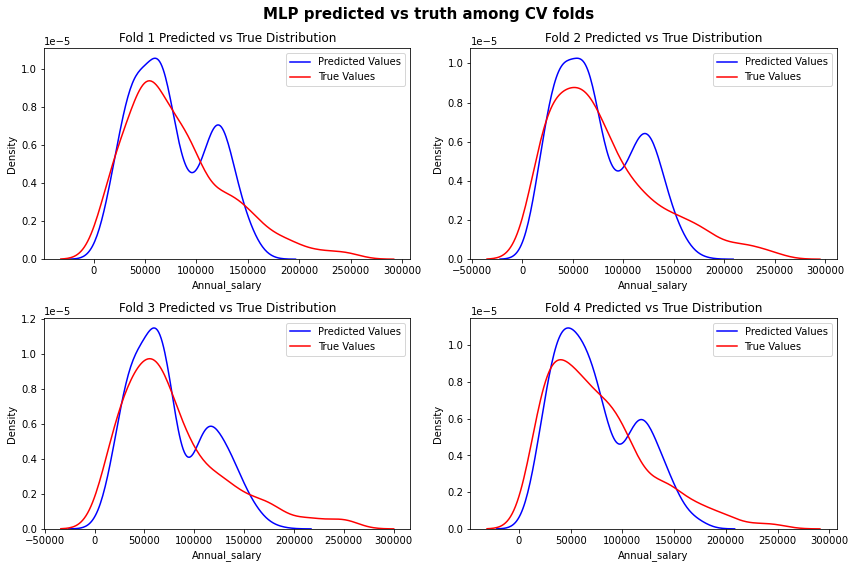

In [14]:
fold_num = 1
plt.figure(figsize=(12, 8))
for train_index, test_index in kf.split(X_train_scaled):
    
    # Extrae los datos para este fold específico
    X_fold_test = X_train_scaled.iloc[test_index]
    y_fold_true = y_train.iloc[test_index]
    
    # Realiza las predicciones para este fold
    y_fold_pred = clf.predict(X_fold_test)

    # Crear un subplot para cada fold
    plt.subplot(2, 2, fold_num)
    sns.kdeplot(y_fold_pred, color='blue', label='Predicted Values')
    sns.kdeplot(y_fold_true, color='red', label='True Values')
    plt.title(f'Fold {fold_num} Predicted vs True Distribution')
    plt.legend()

    fold_num += 1

plt.suptitle('MLP predicted vs truth among CV folds', weight='bold', fontsize=15)
plt.tight_layout()
plt.show()

### 3.2. Train and Test sets predictions

First, let's update model with the best parameters found in CV:

Now, we will define our metrics for train and test sets:

In [15]:
def adjusted_r2(r2, n, p):
    """Calculate adjusted R^2 given R^2, number of observations (n) and number of predictors (p)"""
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
    
def metrics(model, X, y):
    """
    Calculate average metrics (R^2, RMSE, Adjusted R^2) and predictions from cross-validation results
    and return them
    """
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, y_pred)
    adj_r2 = adjusted_r2(r2, X.shape[0], X.shape[1])
    
    return {'R^2': r2, 'RMSE': rmse, 'Adjusted R^2': adj_r2, 'Predictions': y_pred}

#### 3.2.1. Train set results


Train set metrics:
R^2: 0.6314306040936548
RMSE: 30876.34950817057
Adjusted R^2: 0.6157685327664568


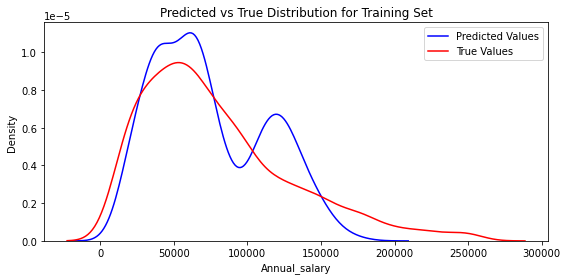

In [16]:
train_results = metrics(clf.best_estimator_, X_train_scaled, y_train)

print("\nTrain set metrics:")
for key in list(train_results.keys())[:3]:
    print(f"{key}: {train_results[key]}")

y_train_pred = clf.best_estimator_.predict(X_train_scaled)

plt.figure(figsize=(8, 4))

sns.kdeplot(y_train_pred, color='blue', label='Predicted Values')
sns.kdeplot(y_train, color='red', label='True Values')
plt.title('Predicted vs True Distribution for Training Set')
plt.legend()

plt.tight_layout()
plt.show()


Test set metrics:
R^2: 0.617081148495998
RMSE: 30663.417721682195
Adjusted R^2: 0.5404973781951976


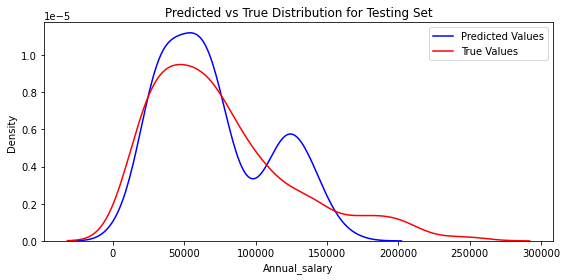

In [17]:
test_results = metrics(clf.best_estimator_, X_test_scaled, y_test)

print("\nTest set metrics:")
for key in list(test_results.keys())[:3]:
    print(f"{key}: {test_results[key]}")

y_test_pred = clf.best_estimator_.predict(X_test_scaled)

plt.figure(figsize=(8, 4))

# Plotting
sns.kdeplot(y_test_pred, color='blue', label='Predicted Values')
sns.kdeplot(y_test, color='red', label='True Values')
plt.title('Predicted vs True Distribution for Testing Set')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
y_pred_train = train_results['Predictions']
y_pred_test = test_results['Predictions']

## 4. Plotting results

### 4.1. Residuals Plot

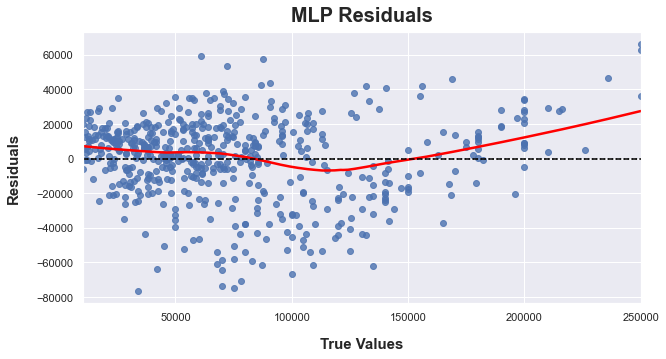

In [19]:
sns.set_theme(style='darkgrid')

residuals = y_test - y_pred_test

plt.figure(figsize=(10,5))

sns.residplot(x=y_test, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 2.5})

plt.title('MLP Residuals', weight='bold', fontsize=20, pad=10)
plt.xlabel('True Values', weight='bold', fontsize=15, labelpad= 15)
plt.ylabel('Residuals', weight='bold', fontsize=15, labelpad= 15)
plt.axhline(y=0, color='black', linestyle='--')
plt.savefig("../../paper/models/mlp-test-residuals.pdf");

### 4.2. Test set performance

<Figure size 720x432 with 0 Axes>

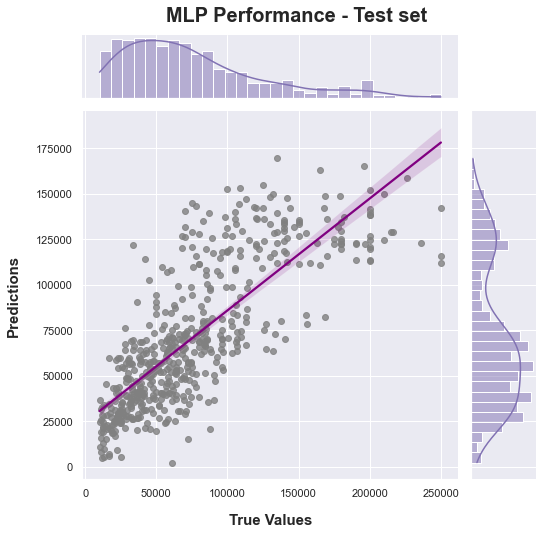

In [20]:
sns.set_theme(style='darkgrid')

plt.figure(figsize=(10, 6))

sns.jointplot(x=y_test, y=y_pred_test, kind='reg', 
              joint_kws={'color':'grey', 'line_kws':{'color':'purple'}},
              marginal_kws=dict(bins=30, fill=True, color='m'), height=7)

plt.suptitle('MLP Performance - Test set', weight='bold', y=1.03, fontsize=20)
plt.xlabel('True Values', weight='bold', labelpad=15, fontsize=15)
plt.ylabel('Predictions', weight='bold', labelpad=15, fontsize=15)

plt.savefig("../../paper/models/mlp-test-predictions.pdf");

### 4.3. Train vs Test loss

Epoch 1/20
71/71 [==============================] - 2s 10ms/step - loss: 77516.1172 - val_loss: 68156.1484
Epoch 2/20
71/71 [==============================] - 0s 6ms/step - loss: 51390.9023 - val_loss: 33718.5078
Epoch 3/20
71/71 [==============================] - 1s 7ms/step - loss: 30579.3242 - val_loss: 25483.1758
Epoch 4/20
71/71 [==============================] - 0s 7ms/step - loss: 25783.4004 - val_loss: 23059.4766
Epoch 5/20
71/71 [==============================] - 0s 6ms/step - loss: 24314.5410 - val_loss: 22290.9824
Epoch 6/20
71/71 [==============================] - 0s 6ms/step - loss: 23474.3926 - val_loss: 22065.9199
Epoch 7/20
71/71 [==============================] - 0s 6ms/step - loss: 23168.9355 - val_loss: 22168.3691
Epoch 8/20
71/71 [==============================] - 1s 7ms/step - loss: 22997.7422 - val_loss: 22051.8574
Epoch 9/20
71/71 [==============================] - 1s 9ms/step - loss: 22567.9844 - val_loss: 22143.3555
Epoch 10/20
71/71 [==========================

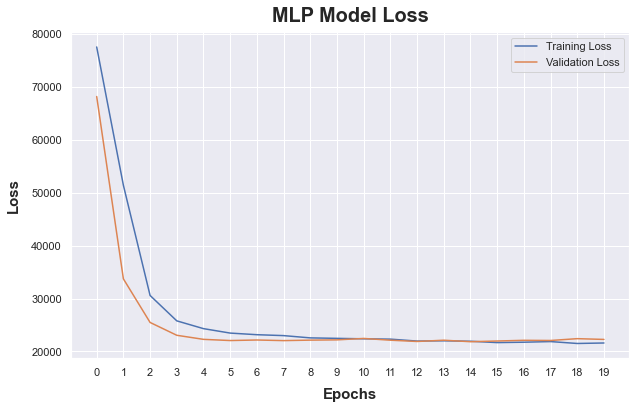

In [27]:
best_model = create_model(**best_params)

history = best_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test), 
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size']
)

num_epochs = best_params['epochs']

sns.set()
plt.figure(figsize=(10, 6))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('MLP Model Loss', fontsize=20, weight='bold', pad=10)
plt.xlabel('Epochs', fontsize=15, weight='bold', labelpad=10)
plt.ylabel('Loss', fontsize=15, weight='bold', labelpad=10)
plt.xticks(np.arange(0, num_epochs, step=1))

plt.legend()
plt.savefig("../../paper/models/mlp-train-vs-test-loss.pdf")
plt.show()

The regularization terms (dropout) are only applied while training the model on the training set, inflating the training loss. During validation and testing, your loss function only comprises prediction error, resulting in a generally lower loss than the training set.

## 6. Saving results

Saving CV results

In [22]:
df_cv_results.to_csv("../../output/mlp-cv-results.csv")

Saving train and test sets predictions

In [23]:
np.savetxt("../../output/mlp-train-predictions.csv", y_pred_train, delimiter=",")

np.savetxt("../../output/mlp-test-predictions.csv", y_pred_test, delimiter=",")

In [24]:
pd.set_option('display.max_colwidth', None)


df_cv_results[['params', 'mean_train_r2', 'mean_test_r2', 'mean_train_rmse', 'mean_test_rmse']]

,params,mean_train_r2,mean_test_r2,mean_train_rmse,mean_test_rmse
0,"{'optimizer': 'Adam', 'neurons': 256, 'loss': 'huber_loss', 'init': 'he_uniform', 'extra_layer': True, 'epochs': 20, 'dropout_rate': 0.1, 'batch_size': 32, 'activation': 'leakyrelu'}",0.640208,0.578702,30502.629928,32967.70249
